In [28]:
# import packages
import numpy as np
import pandas as pd
import os
import seaborn as sns
import Bio
import matplotlib.pyplot as plt
import ast
import scipy.stats as stats
from scipy.optimize import curve_fit

In [29]:
# import data

path: str = './data/' #folder where files are stored
prokaryotes_all: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_all.csv"), dtype=str)
prokaryotes_values: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_funct.csv"), dtype=str)

prokaryotes_lysate: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_322columns.csv"))

prokaryotes_values['a_point'] = prokaryotes_values['a_point'].astype('float64')
prokaryotes_values['b_point'] = prokaryotes_values['b_point'].astype('float64')
prokaryotes_values['plateau'] = prokaryotes_values['plateau'].astype('float64')
prokaryotes_values['meltPoint'] = prokaryotes_values['meltPoint'].astype('float64')

/var/folders/pm/vzcy9py91xzg_z5d80js6mtc0000gn/T/ipykernel_39251/1952307281.py:7: DtypeWarning: Columns (6,19,20,21,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  prokaryotes_lysate: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_322columns.csv"))


In [30]:
# x = np.array([1.1, 2.1, 3, 4.5, 5.3, 6])
# y = np.array([1, 2.4, 3.1, 4.4, 5, 6.7])
# plt.plot(x, y, 'o')

# def linear(x, A, B):
#     y = A*x + B
#     return y

# parameters, covariance = curve_fit(linear, x, y)

# fit_y = linear(x, parameters[0], parameters[1])
# plt.plot(x, y, 'o', label='data')
# plt.plot(x, fit_y, '-', label='fit')
# plt.legend()

In [31]:
# protein = prokaryotes_all.groupby('Protein_ID')
# protein_keys = list(protein.groups.keys())
# temp = np.asarray(protein.get_group(protein_keys[0])['temperature'])
# fold_change = np.asarray((protein.get_group(protein_keys[0])['fold_change']).astype('float64').min()/protein.get_group(protein_keys[0])['fold_change'].astype('float64'))
# plt.plot(temp, fold_change, 'o')


In [32]:
def curve_equation(x, a, b, plateau, target):
    rel_amount = ((1-plateau)/(1+(np.power(np.e, (-a/x)+b)))) + plateau
    return rel_amount - target
from scipy.optimize import fsolve
prokaryotes_values['solution'] = pd.Series(prokaryotes_values.index).apply(lambda i: fsolve(curve_equation, prokaryotes_values.loc[i, 'meltPoint'], args=(prokaryotes_values.loc[i,'a_point'], prokaryotes_values.loc[i,'b_point'], prokaryotes_values.loc[i,'plateau'], 0.1)))
prokaryotes_values = prokaryotes_values[prokaryotes_values['solution'] < 100]
#essential_proteins_bs = prokaryotes_values[(prokaryotes_values['Sample'] == 'B.subtilis_P023755') & (prokaryotes_values['solution'] < 54) & (prokaryotes_values['solution'] > 52)]


/var/folders/pm/vzcy9py91xzg_z5d80js6mtc0000gn/T/ipykernel_39251/4009417203.py:5: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  prokaryotes_values['solution'] = pd.Series(prokaryotes_values.index).apply(lambda i: fsolve(curve_equation, prokaryotes_values.loc[i, 'meltPoint'], args=(prokaryotes_values.loc[i,'a_point'], prokaryotes_values.loc[i,'b_point'], prokaryotes_values.loc[i,'plateau'], 0.1)))


In [33]:
prokaryotes_lysate=prokaryotes_lysate.reset_index().merge(prokaryotes_values.reset_index(), on='Protein_ID', how='inner')

prokaryotes_lysate = prokaryotes_lysate.drop(columns=prokaryotes_lysate.columns[30:318])

In [34]:
#add GO groups to dataframe
# for n in prokaryotes_lysate.index:
#     if pd.notna(prokaryotes_lysate.loc[n, 'Gene Ontology (biological process)']):
#         prokaryotes_lysate.loc[n, 'GO_Group'] = prokaryotes_lysate.loc[n,'Gene Ontology (biological process)'].str.split(';').str[0]

# Iterate over the rows in the DataFrame
for n in prokaryotes_lysate.index:
    go_process = prokaryotes_lysate.loc[n, 'Gene Ontology (biological process)']
    if pd.notna(go_process):
        prokaryotes_lysate.loc[n, 'GO_Group'] = go_process.split(';')[0]


In [35]:
for n in prokaryotes_lysate.index: 
    if prokaryotes_lysate.loc[n,'Organism'] == 'Bacillus subtilis (strain 168)':
        prokaryotes_lysate.loc[n, 'max_temp'] = 53 
    elif prokaryotes_lysate.loc[n, 'Organism'] == 'Escherichia coli (strain K12)':
        prokaryotes_lysate.loc[n, 'max_temp'] = 46 
    elif prokaryotes_lysate.loc[n, 'Organism'] == 'Oleispira antarctica RB-8':
        prokaryotes_lysate.loc[n, 'max_temp'] = 28
    elif prokaryotes_lysate.loc[n, 'Organism'] == 'Thermus thermophilus (strain ATCC BAA-163 / DSM 7039 / HB27)':
        prokaryotes_lysate.loc[n, 'max_temp'] = 82
    elif prokaryotes_lysate.loc[n, 'Organism'] == 'Escherichia coli str. K-12 substr. MG1655':
        prokaryotes_lysate.loc[n, 'max_temp'] = 46
    elif prokaryotes_lysate.loc[n, 'Organism'] == 'Picrophilus torridus (strain ATCC 700027 / DSM 9790 / JCM 10055 / NBRC 100828 / KAW 2/3)':
        prokaryotes_lysate.loc[n, 'max_temp'] = 66

In [36]:
GO_groups_bioprocess = prokaryotes_lysate.groupby(prokaryotes_lysate['Gene Ontology (biological process)'].str.split(';').str[0])
GO_keys_bioprocess = list(GO_groups_bioprocess.groups.keys())
GO_keys_bioprocess = pd.Series(GO_keys_bioprocess)

In [37]:
heatmap_1 = pd.DataFrame()

# for key, group in GO_groups_bioprocess:
#     for n in group:
#         if group[n,'Organism'] == 'Bacillus subtilis (strain 168)':
#             print(group[n,'Organism'])

for name, group in GO_groups_bioprocess:
    print(f"GO Group {name}:")
    organism_df = group[group['Organism'] == 'Bacillus subtilis (strain 168)']
    if not organism_df.empty:
        mean_solution = organism_df['solution'].mean()
        print(f"Mean 'solution' for {'Bacillus subtilis (strain 168)'} in group {name}: {mean_solution}")
    else:
        print(f"{'Bacillus subtilis (strain 168)'} not found in group {name}")


GO Group 'de novo' AMP biosynthetic process [GO:0044208]:
Mean 'solution' for Bacillus subtilis (strain 168) in group 'de novo' AMP biosynthetic process [GO:0044208]: [60.51456649]
GO Group 'de novo' CTP biosynthetic process [GO:0044210]:
Mean 'solution' for Bacillus subtilis (strain 168) in group 'de novo' CTP biosynthetic process [GO:0044210]: [77.14824443]
GO Group 'de novo' IMP biosynthetic process [GO:0006189]:
Mean 'solution' for Bacillus subtilis (strain 168) in group 'de novo' IMP biosynthetic process [GO:0006189]: [67.3318081]
GO Group 'de novo' L-methionine biosynthetic process [GO:0071266]:
Bacillus subtilis (strain 168) not found in group 'de novo' L-methionine biosynthetic process [GO:0071266]
GO Group 'de novo' NAD biosynthetic process from aspartate [GO:0034628]:
Mean 'solution' for Bacillus subtilis (strain 168) in group 'de novo' NAD biosynthetic process from aspartate [GO:0034628]: [61.38746853]
GO Group 'de novo' UMP biosynthetic process [GO:0044205]:
Mean 'solution'

In [38]:
organisms = prokaryotes_lysate['Organism'].unique()
matrix = pd.DataFrame(index=GO_groups_bioprocess.groups.keys(), columns=organisms)

for name, group in GO_groups_bioprocess:
    for organism in organisms:
        organism_df = group[group['Organism'] == organism]
        if not organism_df.empty:
            mean_solution = organism_df['solution'].mean()
            max_temp = organism_df['max_temp'].iloc[0]
            difference = abs(mean_solution - max_temp)
            matrix.at[name, organism] = difference
matrix1 = matrix.apply(pd.to_numeric, errors='coerce').fillna(100)

print(matrix)

matrix2 = matrix1.astype(float)
matrix2= matrix2.drop(['Escherichia coli str. K-12 substr. MG1655','Thermus thermophilus','Escherichia coli O157:H7',], axis=1)


                                                   Bacillus subtilis (strain 168)  \
'de novo' AMP biosynthetic process [GO:0044208]                7.5145664906239915   
'de novo' CTP biosynthetic process [GO:0044210]                 24.14824443246124   
'de novo' IMP biosynthetic process [GO:0006189]                14.331808104185086   
'de novo' L-methionine biosynthetic process [GO...                            NaN   
'de novo' NAD biosynthetic process from asparta...              8.387468530318955   
...                                                                           ...   
valyl-tRNA aminoacylation [GO:0006438]                                        NaN   
viral process [GO:0016032]                                                    NaN   
wobble position cytosine ribose methylation [GO...                            NaN   
xanthine transport [GO:0042906]                                16.908100488271984   
xenobiotic detoxification by transmembrane expo...               

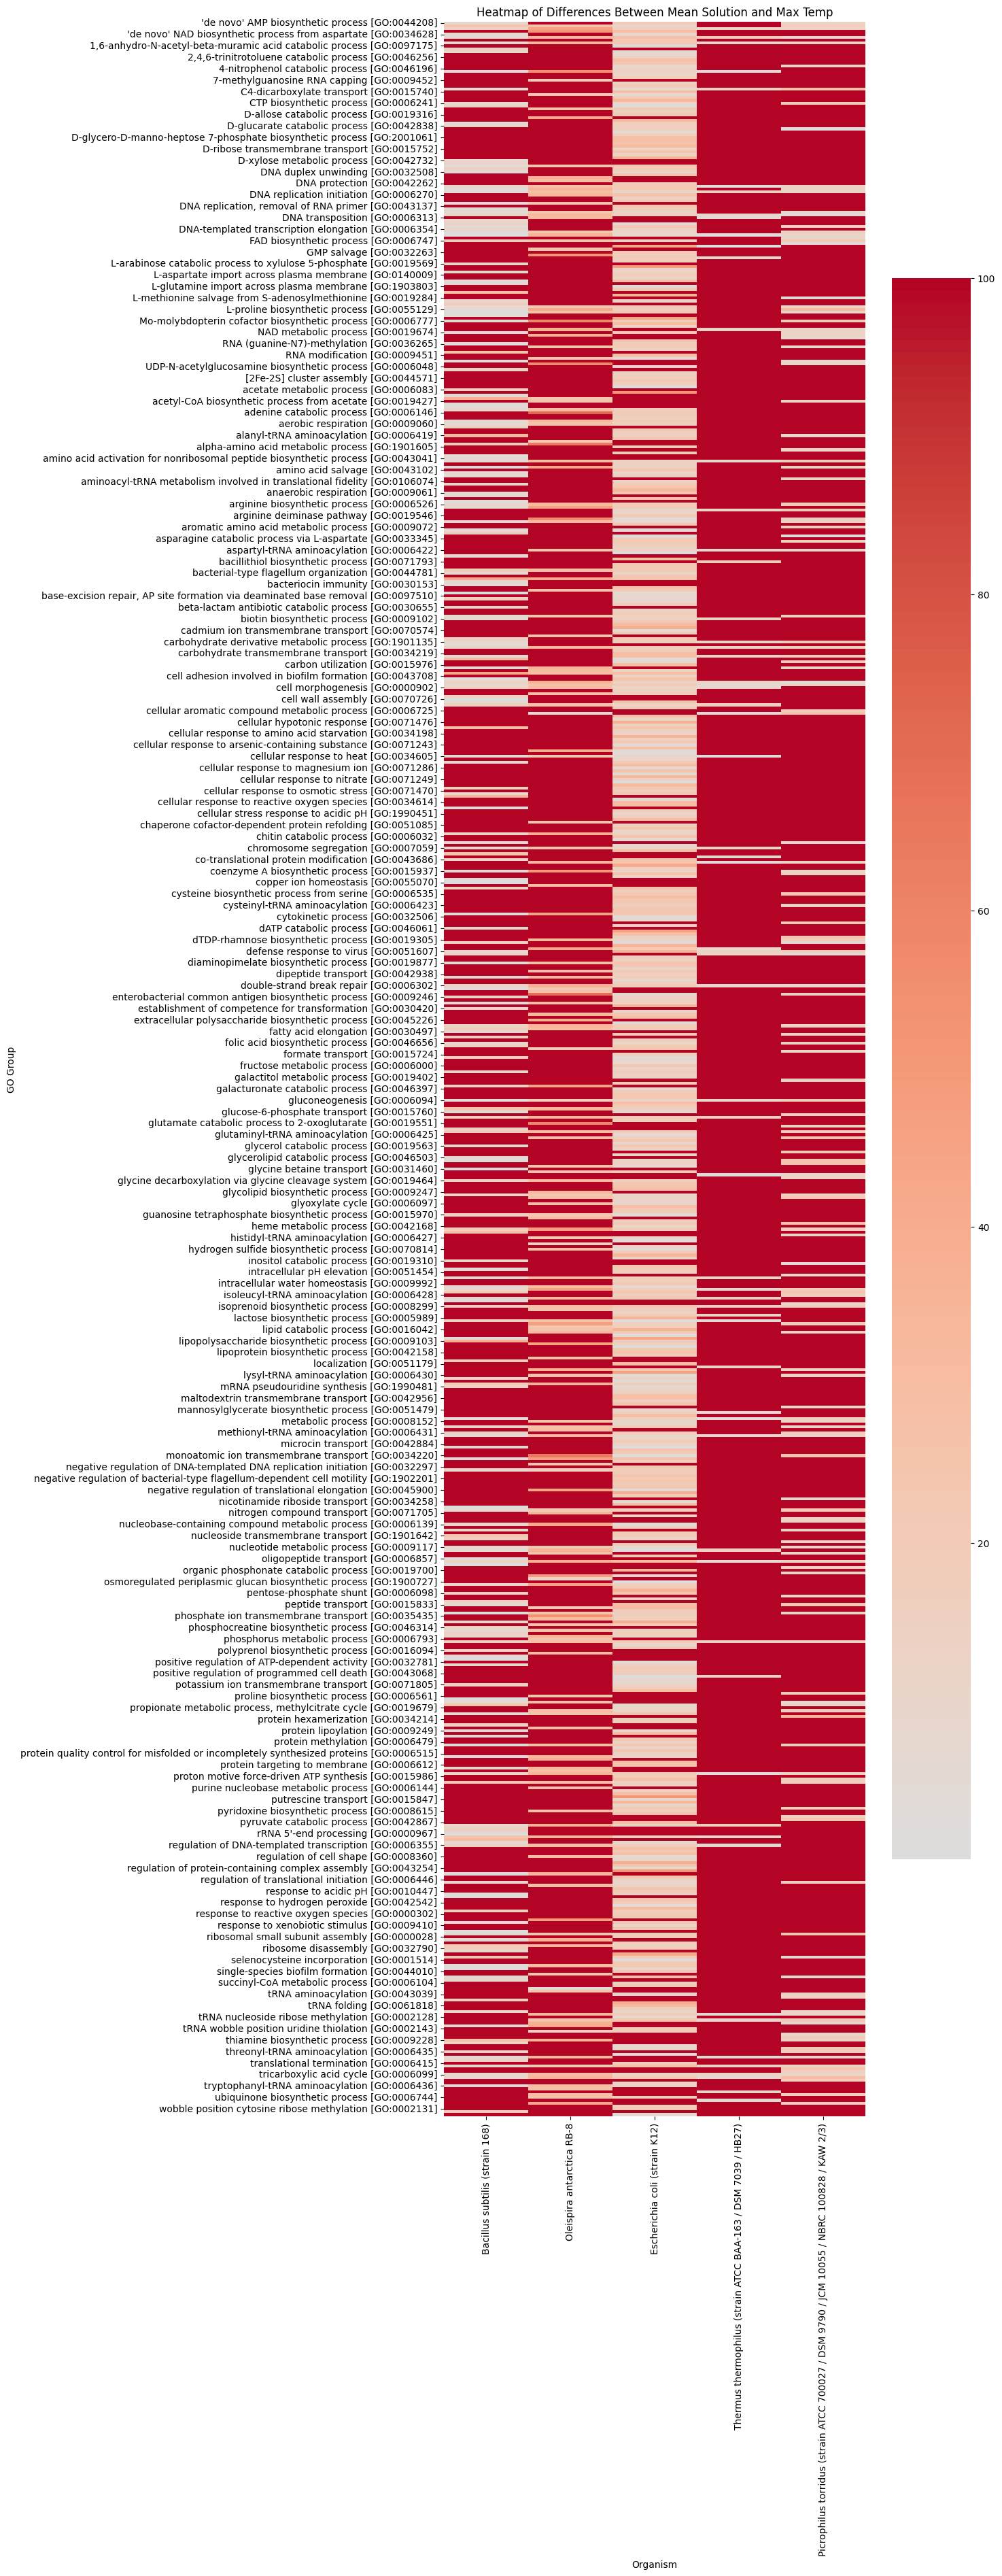

In [39]:
plt.figure(figsize=(10, 40))
heatmap = sns.heatmap(matrix2, annot=False, cmap='coolwarm', center=0, )
plt.title('Heatmap of Differences Between Mean Solution and Max Temp')
plt.xlabel('Organism')
plt.ylabel('GO Group')
plt.show()

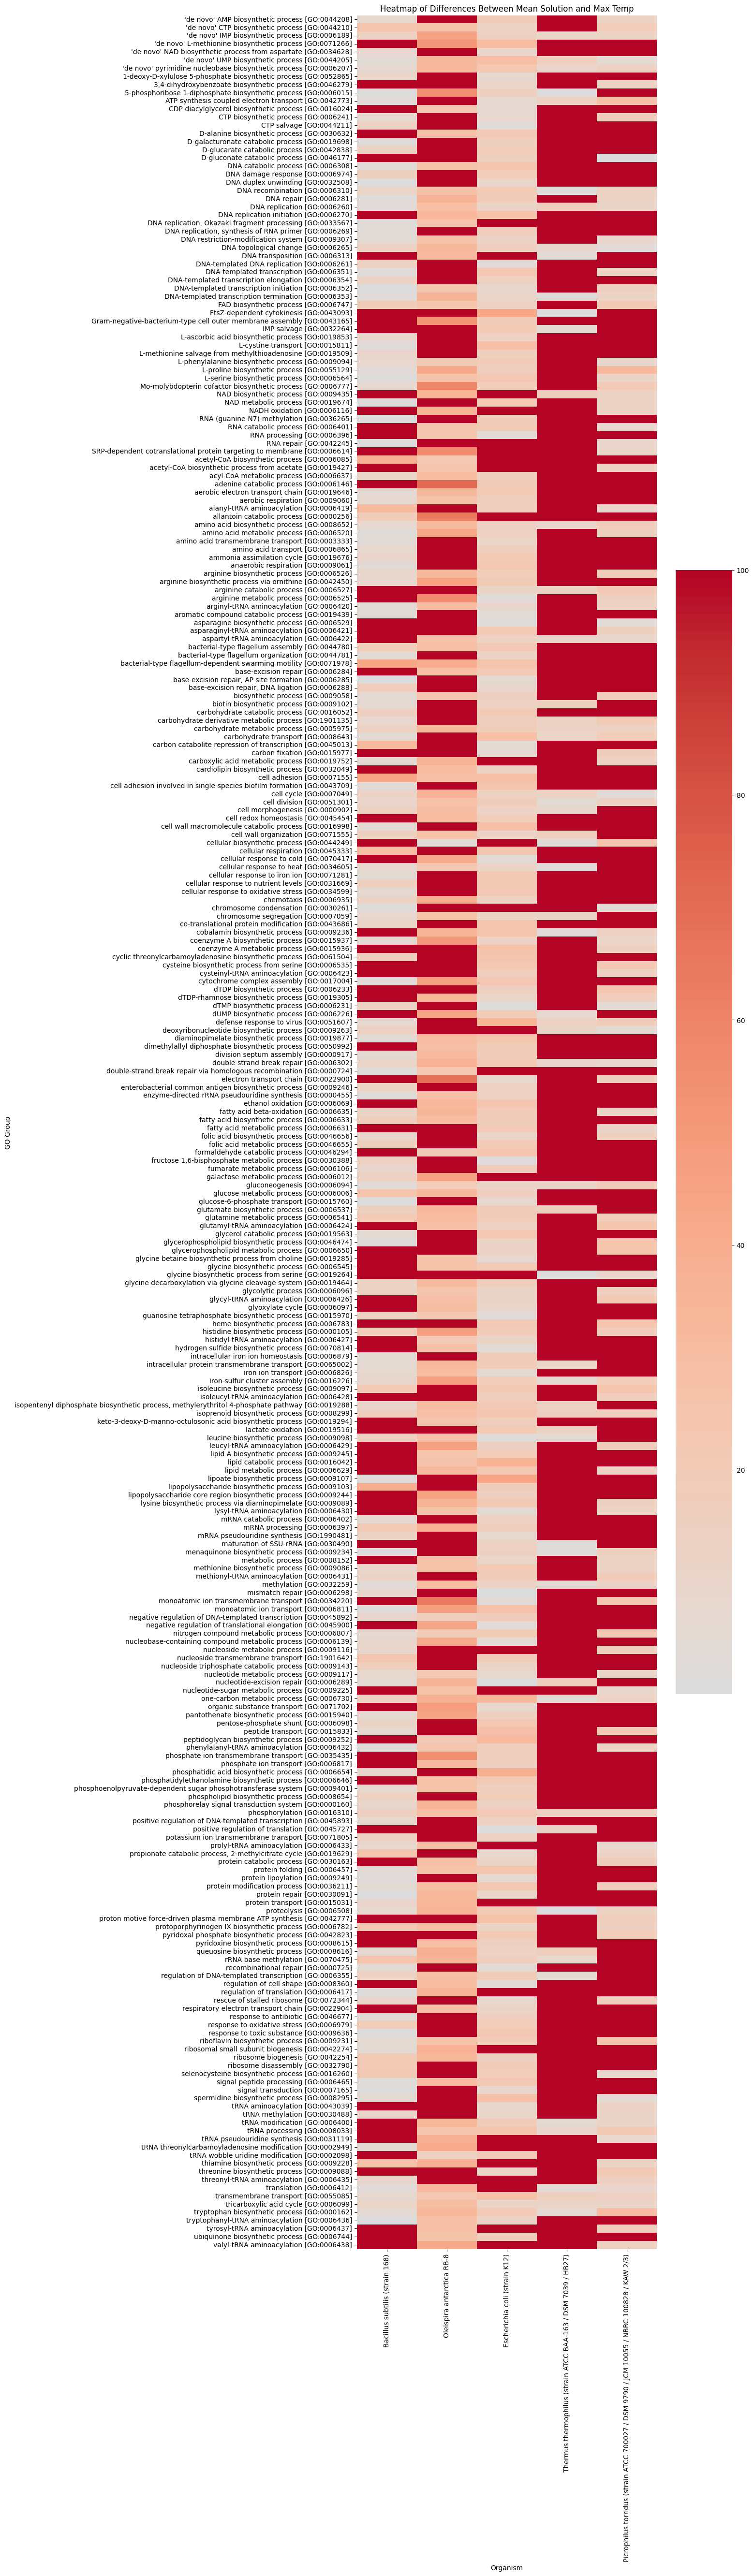

In [40]:
matrix3 = matrix2[(matrix2 == 100).sum(axis=1) < 4]

plt.figure(figsize=(10, 60))
heatmap = sns.heatmap(matrix3, annot=False, cmap='coolwarm', center=0 )
plt.title('Heatmap of Differences Between Mean Solution and Max Temp')
plt.xlabel('Organism')
plt.ylabel('GO Group')
plt.show()

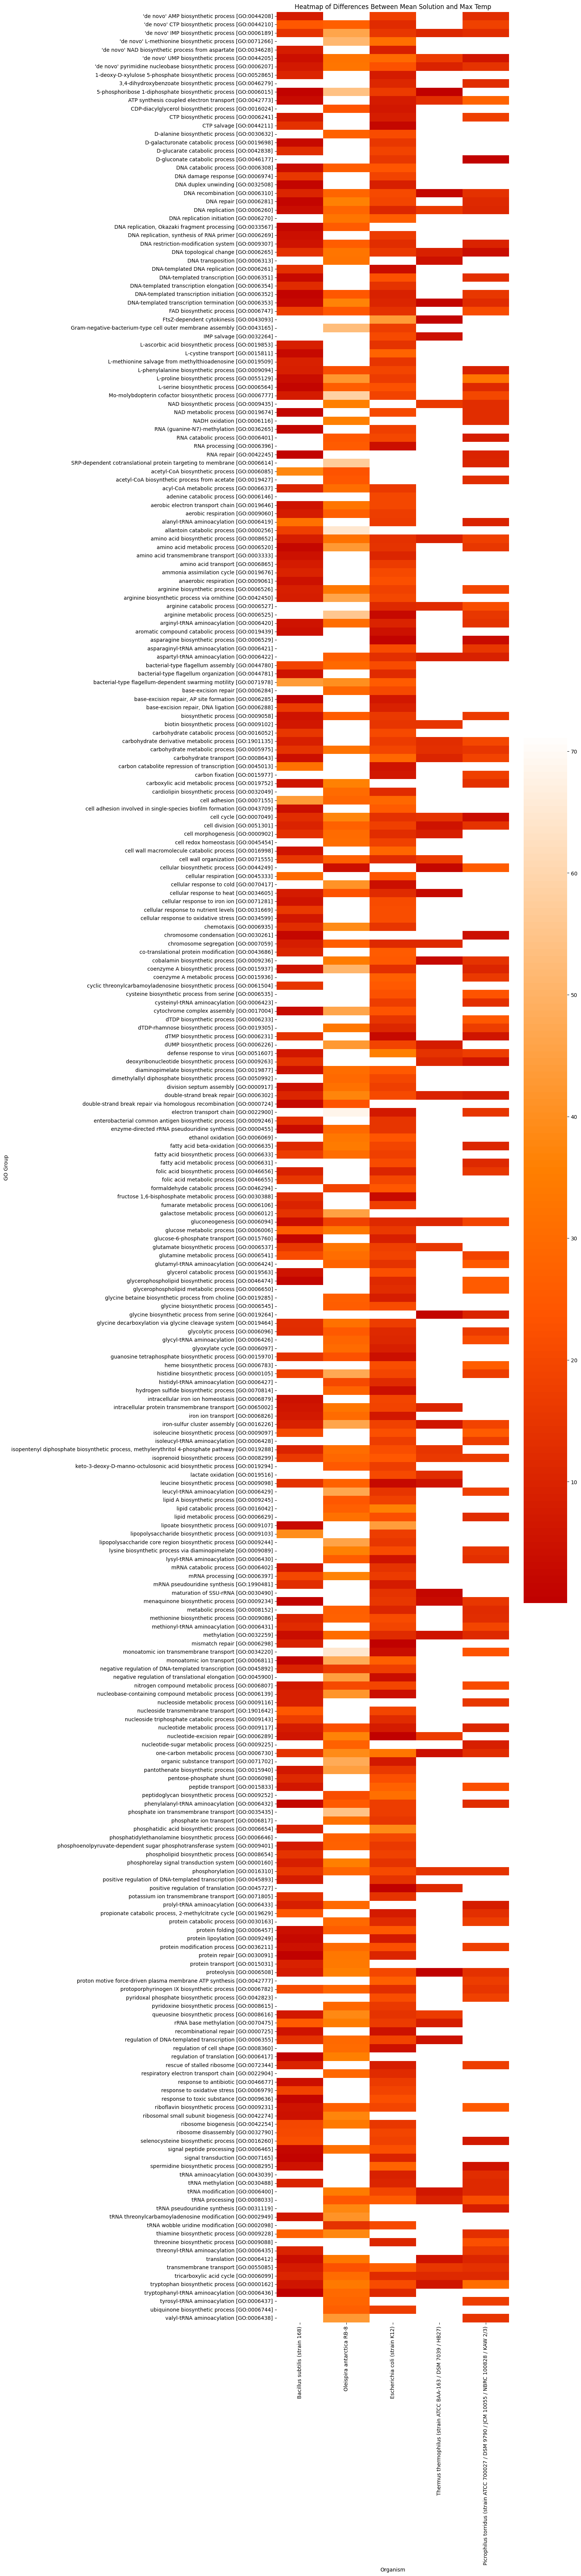

In [41]:
matrix4 = matrix.astype(float)
matrix4= matrix4.drop(['Escherichia coli str. K-12 substr. MG1655','Thermus thermophilus','Escherichia coli O157:H7',], axis=1)
matrix4 = matrix4[matrix4.isnull().sum(axis=1) < 4]

plt.figure(figsize=(10, 80))
heatmap = sns.heatmap(matrix4, annot=False, cmap='gist_heat', center=0, mask=matrix4.isnull() )
plt.title('Heatmap of Differences Between Mean Solution and Max Temp')
plt.xlabel('Organism')
plt.ylabel('GO Group')
plt.show()

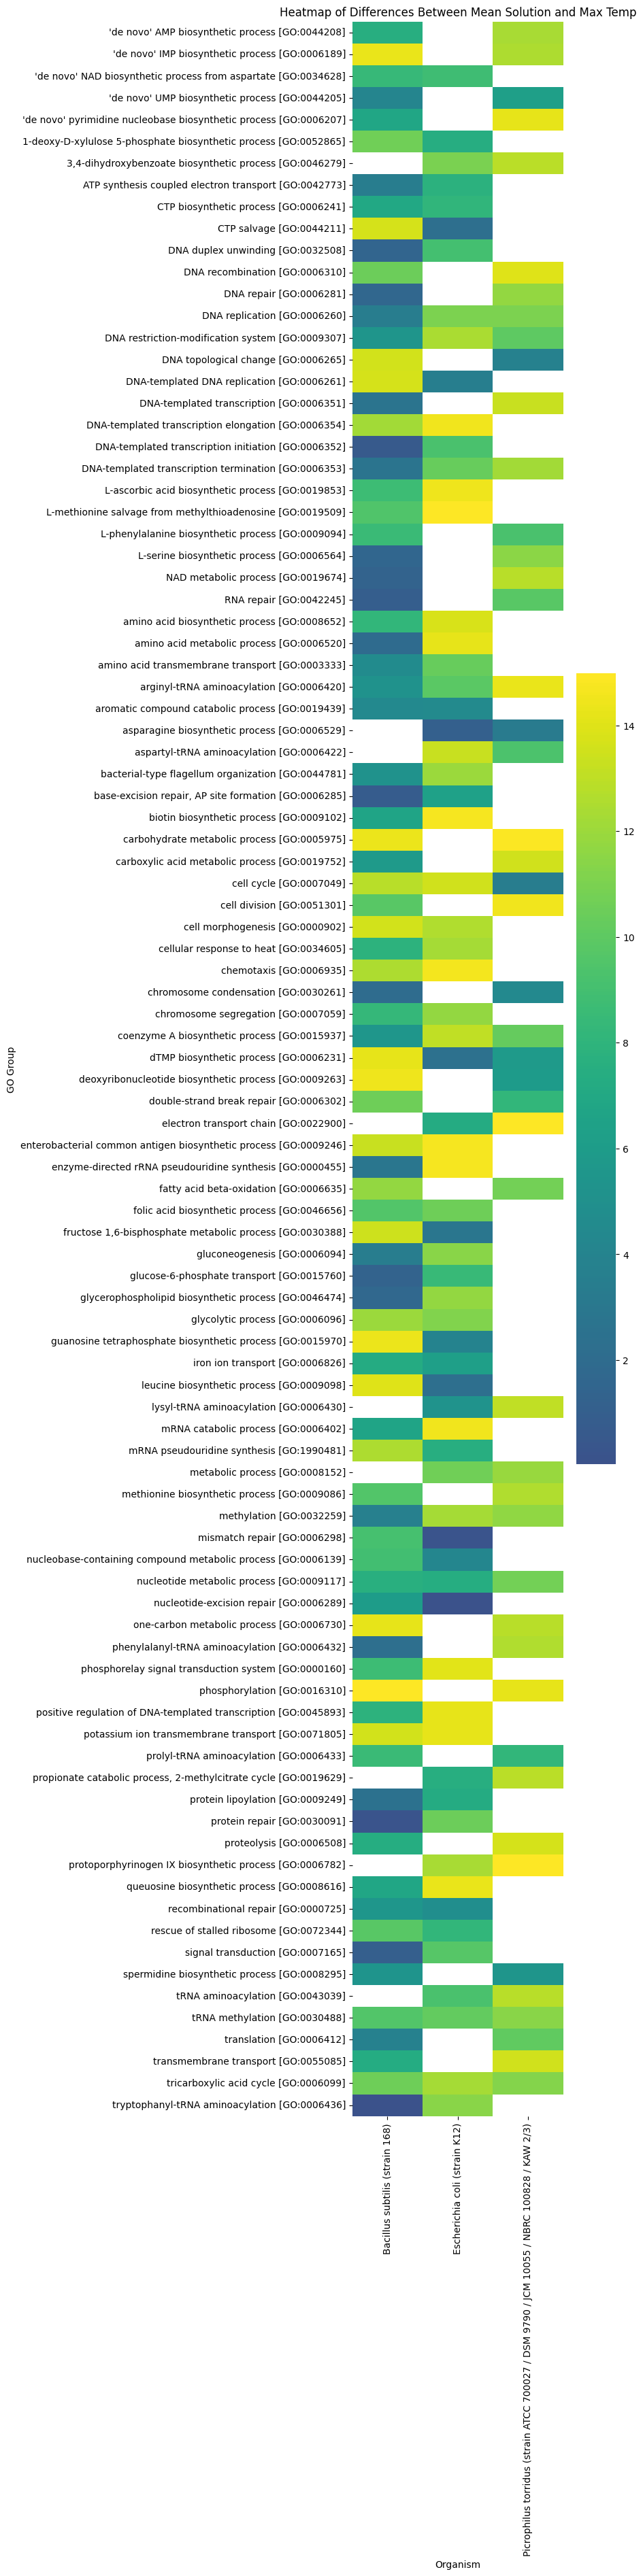

In [42]:
matrix3 = matrix2[matrix2.isnull().sum(axis=1) < 4]
matrix3 = matrix3.drop(columns='Oleispira antarctica RB-8')
matrix3 = matrix3.drop(columns='Thermus thermophilus (strain ATCC BAA-163 / DSM 7039 / HB27)')


for n in matrix3.index:
    for x in matrix3.columns:
        if matrix3.loc[n, x] > 15:
            matrix3.loc[n, x] = np.nan

matrix3 = matrix3[matrix3.isnull().sum(axis=1) < 2]
            


plt.figure(figsize=(5,40))
heatmap = sns.heatmap(matrix3, annot=False, cmap='viridis', center=5 )
plt.title('Heatmap of Differences Between Mean Solution and Max Temp')
plt.xlabel('Organism')
plt.ylabel('GO Group')
plt.show()